#导包

In [36]:
import torch
import torch.nn as nn
from d2l import torch as d2l
from torch.xpu import device

device  = torch.device('mps')
device


device(type='mps')

In [31]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:  # 全连接层
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:  # 卷积层
            mean = X.mean(dim=(0, 2, 3))  # shape: (C,)
            var = ((X - mean.reshape(1, -1, 1, 1)) ** 2).mean(dim=(0, 2, 3))  # shape: (C,)
        # 更新 moving_mean/moving_var
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
        # 使用广播机制进行归一化
        X_hat = (X - mean.reshape(1, -1, 1, 1)) / torch.sqrt(var.reshape(1, -1, 1, 1) + eps)

    Y = gamma.reshape(1, -1, 1, 1) * X_hat + beta.reshape(1, -1, 1, 1)
    return Y, moving_mean, moving_var


In [32]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y


In [33]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)



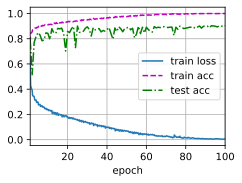

In [38]:
lr , num_epochs, batch_size = 1.0, 100, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)